# Notebook for A Non-Expert’s Guide to Image Segmentation Using Deep Neural Nets

This notebook uses the U-Net model from [this github repo](https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge/) to do pixel-level segmentation of chairs from their background

[Check out the blog post here](https://medium.com/@hanrelan/a-non-experts-guide-to-image-segmentation-using-deep-neural-nets-dda5022f6282)

In [1]:
%matplotlib inline
import brine
import cv2
import numpy as np
from model.augmentations import randomHueSaturationValue, randomShiftScaleRotate, randomHorizontalFlip
import model.u_net as unet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


# Install and load the dataset
We'll use [brine](https://brine.io) to get and load the dataset.

The dataset consists of images of chairs in context and a mask for each image.

[Check out the dataset here](https://www.brine.io/rohan/chairs-with-masks)

In [ ]:
!brine install rohan/chairs-with-masks

In [2]:
chairs = brine.load_dataset('rohan/chairs-with-masks')

In [3]:
print('Dataset size:', len(chairs))
print('Columns:', chairs.columns)
print(chairs[23])

Dataset size: 97
Columns: Column(image=Column(name=image, type=Image), mask=Column(name=mask, type=Image))
Row(image='59.jpg', mask='59_mask.png')


This dataset consists of 97 samples, each with two columns: the image and the mask. We can take a look at what these images look like:

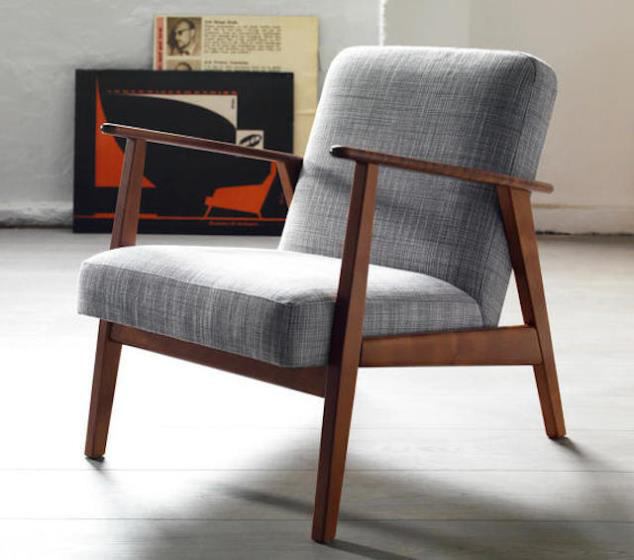

In [4]:
chairs.load_image(chairs[23].image)

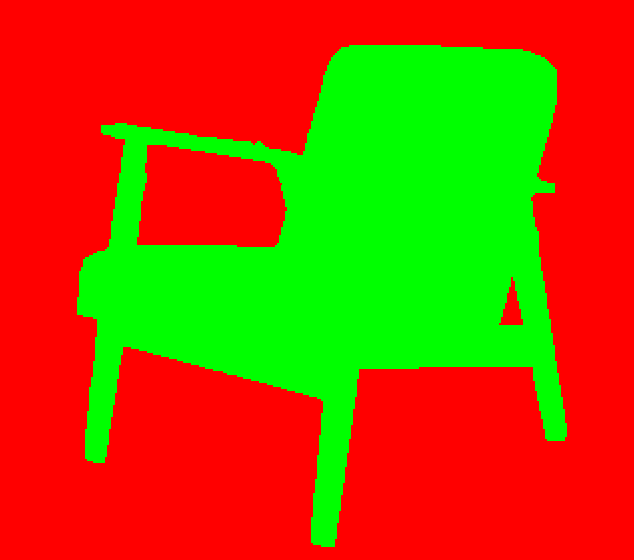

In [5]:
chairs.load_image(chairs[23].mask)

# The model

In [6]:
model = unet.get_unet_256(num_classes=1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Note the input is a 256x256x3 numpy array (the source image), and the output will be a 256x256x1 numpy array (the mask). brine's `to_keras` method will let us apply a processing function to each row of the image. Let's write our processing functions for the training data and the validation data to get the images into the appropriate shape. We'll also use data augmentation for the training data

In [7]:
SIZE = (256, 256)

In [8]:
# Method to set grayscale mask values to either 0 or 255
def fix_mask(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0

In [9]:
# Processing function for the training data
def train_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = randomHueSaturationValue(img,
                                   hue_shift_limit=(-50, 50),
                                   sat_shift_limit=(0, 0),
                                   val_shift_limit=(-15, 15))
    img, mask = randomShiftScaleRotate(img, mask,
                                       shift_limit=(-0.0625, 0.0625),
                                       scale_limit=(-0.1, 0.1),
                                       rotate_limit=(-20, 20))
    img, mask = randomHorizontalFlip(img, mask)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [10]:
# Processing function for the validation data, no data augmentation
def validation_process(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    fix_mask(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    fix_mask(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

# Create the folds and generators

Using brine's `create_folds` method, we'll split our dataset into validation and training folds, with 20 samples in the validation set and the rest in the training set. We'll then use brine's `to_keras` method to create keras-compatible generators for each of the folds with the appropriate processing function applied

In [11]:
BATCH_SIZE = 1

In [12]:
validation_fold, train_fold = chairs.create_folds((20,))
print('Validation fold size:', len(validation_fold))
print('Train fold size:', len(train_fold))

Validation fold size: 20
Train fold size: 77


In [13]:
train_generator = train_fold.to_keras('image',  # Which column we want to use for our 'xs'
                                      'mask',   # Which column we want to use for our 'ys'
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      processing_function=train_process)

In [14]:
validation_generator = validation_fold.to_keras('image',
                                                'mask',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                processing_function=validation_process)

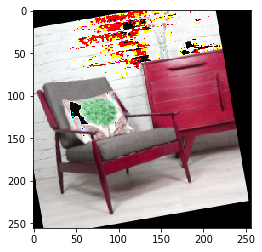

In [15]:
image, mask = next(train_generator)
plt.imshow(image[0])

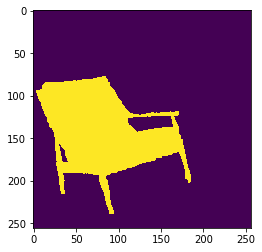

In [16]:
plt.imshow(mask[0].reshape(SIZE))

# Training the model

We'll use the same callbacks as petrosgk's Carvana example. Early stopping to stop when our validation loss stops improving, reducing the learning rate based on validation loss and we save our best model. Then we'll train using keras' `fit_generator` for up to 100 epochs (though likely with this dataset we'll stop before then). 

In [17]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [19]:
epochs=100
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch())

Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 0.7248 - dice_coeff: 0.6672 - val_loss: 1.1701 - val_dice_coeff: 0.3705
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.6737 - dice_coeff: 0.6908 - val_loss: 1.5078 - val_dice_coeff: 0.2359
Epoch 3/100
77/77 [==============================] - ETA: 0s - loss: 0.6161 - dice_coeff: 0.7168 - val_loss: 1.0897 - val_dice_coeff: 0.4578
Epoch 4/100
77/77 [==============================] - ETA: 0s - loss: 0.5877 - dice_coeff: 0.7298 - val_loss: 0.9901 - val_dice_coeff: 0.5505
Epoch 5/100
77/77 [==============================] - ETA: 0s - loss: 0.5458 - dice_coeff: 0.7472 - val_loss: 0.9400 - val_dice_coeff: 0.6893
Epoch 6/100
77/77 [==============================] - ETA: 0s - loss: 0.5085 - dice_coeff: 0.7643 - val_loss: 0.6679 - val_dice_coeff: 0.7305
Epoch 7/100
77/77 [==============================] - ETA: 0s - loss: 0.4744 - dice_coeff: 0.7792 - val_loss: 0.7548 - val_dice_coeff: 0.7160
Epoch 8/100
7

# Using the model to make predictions

We'll load our best weights and use some images from the validation set to check out how our model does. Note it's kind of cheating to set the best weights based on validation data and then test on validation data, so you can also skip the next line and use the final weights.

In [20]:
model.load_weights('weights/best_weights.hdf5')

In [21]:
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]
    predicted_mask = predicted_mask_batch[0].reshape(SIZE)
    plt.imshow(image)
    plt.imshow(predicted_mask, alpha=0.6)

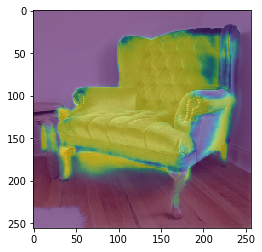

In [26]:
predict_one()